In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('./')
import json
import os
import qiskit
from qiskit import QuantumCircuit
import numpy as np
from dataclasses import dataclass
from enum import auto, Enum
import matplotlib.pyplot as plt
import math
import pandas as pd
from qiskit.visualization import plot_error_map
from component.a_backend.fake_backend import *
from mqt.bench.targets import get_available_gateset_names, get_available_device_names
from mqt.bench import BenchmarkLevel, get_benchmark
from mqt.bench.targets import get_device, get_target_for_gateset
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
from qiskit.transpiler import generate_preset_pass_manager
 
from qiskit.circuit import QuantumCircuit
from qiskit.visualization import plot_histogram
from component.sup_sys.backend_loader import load_backends
from qiskit.visualization import plot_error_map
from component.c_circuit_work.knitting.width_k import *
from qiskit.transpiler import *

In [6]:
backend0 = FakeAthensV2() # chu M nguoc 
backend0.name

'fake_athens'

In [26]:
backend0 = FakeAthensV2() # chu M nguoc 
backend1 = FakeBelemV2() # W huyen
backend2 = FakeBurlingtonV2() # W huyen
backend3 = FakeYorktownV2() # connection
list_backend = [backend0, backend1, backend2, backend3]

circuit2 = QuantumCircuit(3)
circuit2.h(0)
circuit2.cx(0, 1)
circuit2.cx(1, 2)
circuit2.cx(0, 2)

print(circuit2.depth())

circuit3 = QuantumCircuit(3)
circuit3.cx(0, 1)
circuit3.cx(1, 2)
circuit3.cx(0, 2)
circuit3.h(0)

results = []

for backend in list_backend:
    for opt_level in [0, 1, 2, 3]:
            # Circuit 2
            depth_before_2 = circuit2.depth()
            transpiled_2 = transpile(circuit2, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_2 = transpiled_2.depth()
            results.append({
                'circuit': 'circuit2',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_2,
                'depth_after': depth_after_2
            })
            # Circuit 3
            depth_before_3 = circuit3.depth()
            transpiled_3 = transpile(circuit3, backend=backend, optimization_level=opt_level, scheduling_method="asap")
            depth_after_3 = transpiled_3.depth()
            results.append({
                'circuit': 'circuit3',
                'backend': backend.name,
                'optimization_level': opt_level,
                'scheduling_method': "asap",
                'depth_before': depth_before_3,
                'depth_after': depth_after_3
            })

df_depth = pd.DataFrame(results)
# save results to CSV
df_depth.to_csv('depth_results.csv', index=False)

4


Data shape: (32, 6)

First few rows:
    circuit      backend  optimization_level scheduling_method  depth_before  \
0  circuit2  fake_athens                   0              asap             4   
1  circuit3  fake_athens                   0              asap             4   
2  circuit2  fake_athens                   1              asap             4   
3  circuit3  fake_athens                   1              asap             4   
4  circuit2  fake_athens                   2              asap             4   

   depth_after  
0            9  
1            9  
2            9  
3            9  
4            7  


/tmp/ipykernel_4882/4027236721.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax5.boxplot(data_for_boxplot, labels=[b.replace('fake_', '') for b in backends], patch_artist=True)


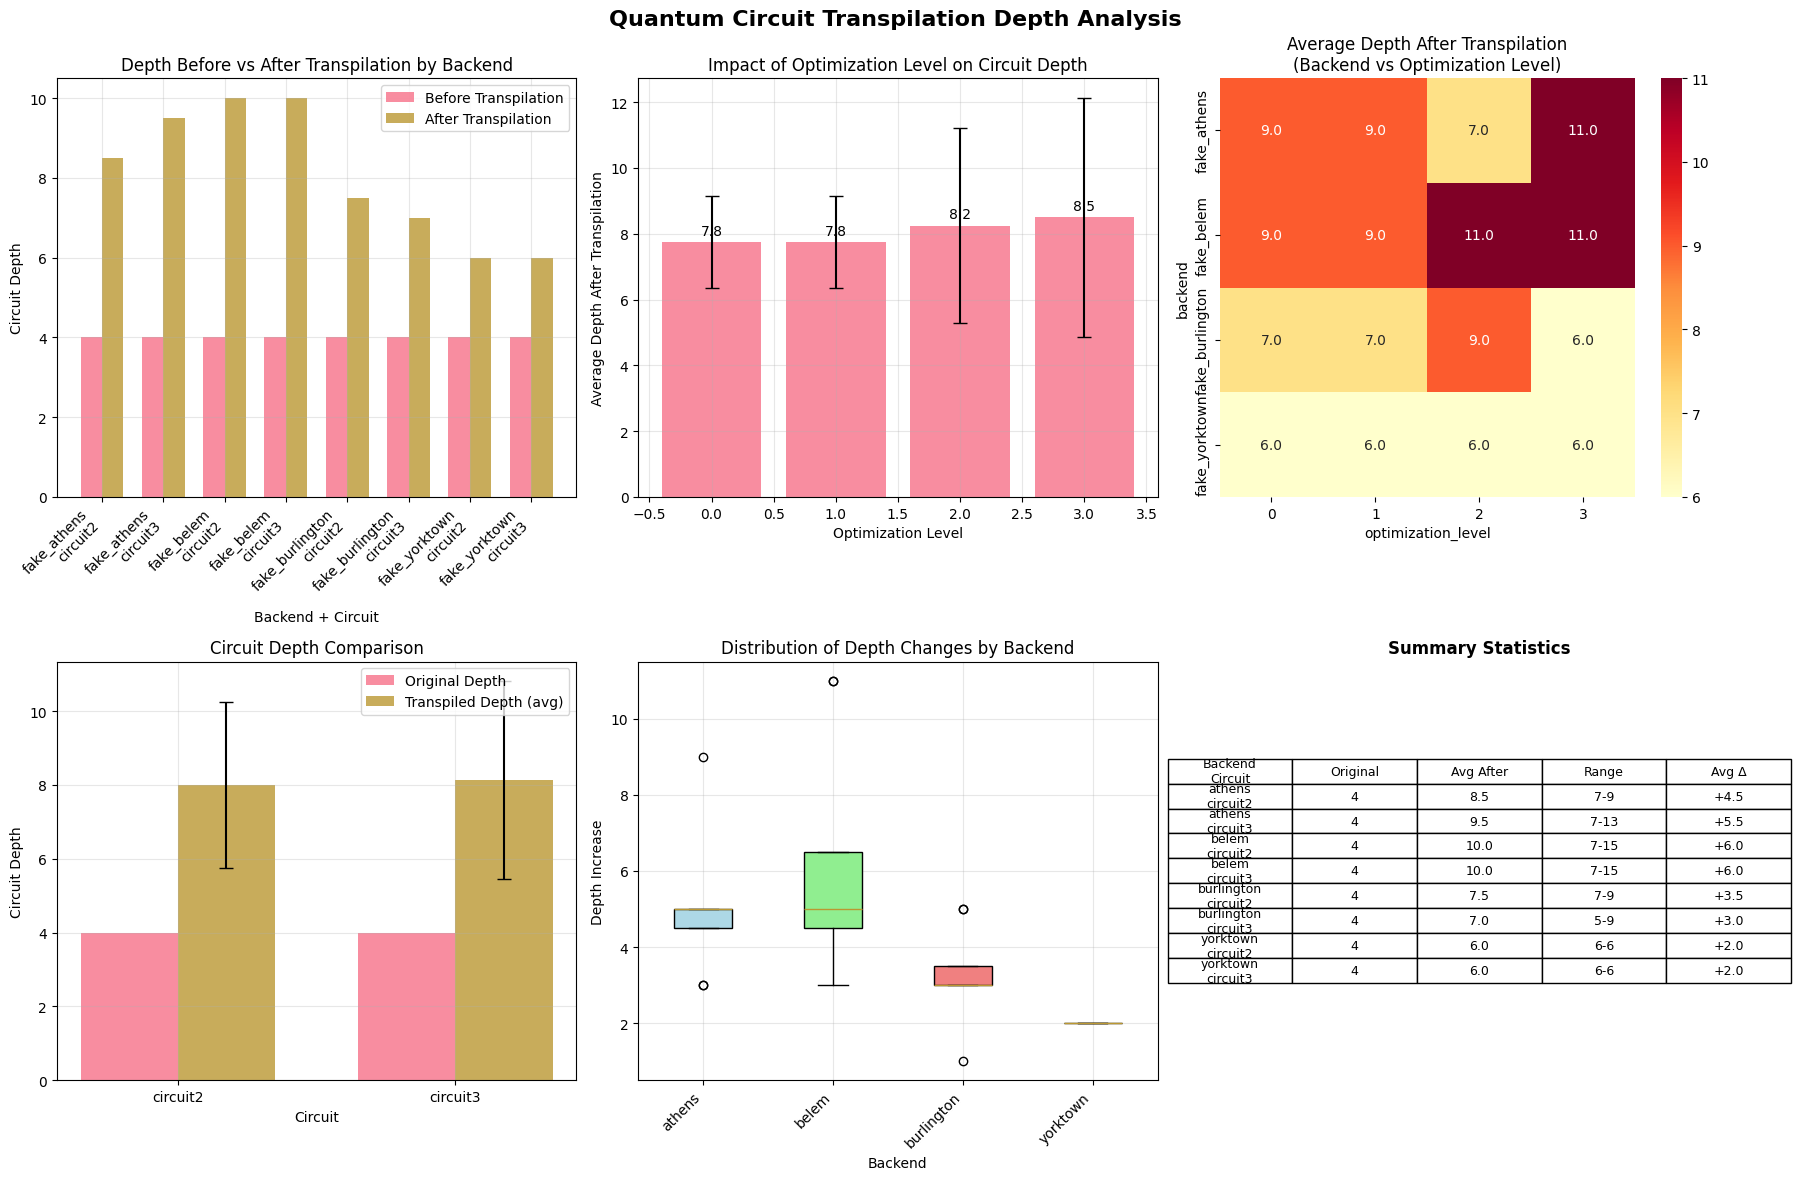


DETAILED ANALYSIS

Overall Statistics:
Average original depth: 4.00
Average transpiled depth: 8.06
Average depth increase: 4.06
Average depth ratio: 2.02

Best performing combinations (lowest final depth):
  circuit3 on fake_burlington (opt=3): depth=5
  circuit2 on fake_yorktown (opt=0): depth=6
  circuit3 on fake_yorktown (opt=0): depth=6
  circuit2 on fake_yorktown (opt=1): depth=6
  circuit3 on fake_yorktown (opt=1): depth=6

Worst performing combinations (highest final depth):
  circuit3 on fake_belem (opt=2): depth=15
  circuit2 on fake_belem (opt=3): depth=15
  circuit3 on fake_athens (opt=3): depth=13
  circuit2 on fake_athens (opt=0): depth=9
  circuit3 on fake_athens (opt=0): depth=9


In [27]:
# Load and visualize the depth results data
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Read the data
df = pd.read_csv('depth_results.csv')
print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Quantum Circuit Transpilation Depth Analysis', fontsize=16, fontweight='bold')

# 1. Depth comparison by backend
ax1 = axes[0, 0]
backend_comparison = df.groupby(['backend', 'circuit']).agg({
    'depth_before': 'mean',
    'depth_after': 'mean'
}).reset_index()

x_pos = range(len(backend_comparison))
width = 0.35
bars1 = ax1.bar([x - width/2 for x in x_pos], backend_comparison['depth_before'], 
                width, label='Before Transpilation', alpha=0.8)
bars2 = ax1.bar([x + width/2 for x in x_pos], backend_comparison['depth_after'], 
                width, label='After Transpilation', alpha=0.8)

ax1.set_xlabel('Backend + Circuit')
ax1.set_ylabel('Circuit Depth')
ax1.set_title('Depth Before vs After Transpilation by Backend')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([f"{row['backend']}\n{row['circuit']}" for _, row in backend_comparison.iterrows()], 
                    rotation=45, ha='right')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Optimization level impact
ax2 = axes[0, 1]
opt_data = df.groupby('optimization_level')['depth_after'].agg(['mean', 'std']).reset_index()
bars = ax2.bar(opt_data['optimization_level'], opt_data['mean'], 
               yerr=opt_data['std'], capsize=5, alpha=0.8)
ax2.set_xlabel('Optimization Level')
ax2.set_ylabel('Average Depth After Transpilation')
ax2.set_title('Impact of Optimization Level on Circuit Depth')
ax2.grid(True, alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.1f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

# 3. Heatmap of depth changes
ax3 = axes[0, 2]
pivot_data = df.pivot_table(values='depth_after', index='backend', 
                           columns='optimization_level', aggfunc='mean')
sns.heatmap(pivot_data, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3)
ax3.set_title('Average Depth After Transpilation\n(Backend vs Optimization Level)')

# 4. Circuit comparison
ax4 = axes[1, 0]
circuit_data = df.groupby('circuit').agg({
    'depth_before': 'mean',
    'depth_after': ['mean', 'std']
}).reset_index()
circuit_data.columns = ['circuit', 'depth_before', 'depth_after_mean', 'depth_after_std']

x_pos = range(len(circuit_data))
bars1 = ax4.bar([x - width/2 for x in x_pos], circuit_data['depth_before'], 
                width, label='Original Depth', alpha=0.8)
bars2 = ax4.bar([x + width/2 for x in x_pos], circuit_data['depth_after_mean'], 
                width, yerr=circuit_data['depth_after_std'], capsize=5,
                label='Transpiled Depth (avg)', alpha=0.8)

ax4.set_xlabel('Circuit')
ax4.set_ylabel('Circuit Depth')
ax4.set_title('Circuit Depth Comparison')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(circuit_data['circuit'])
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Depth increase distribution
ax5 = axes[1, 1]
df['depth_increase'] = df['depth_after'] - df['depth_before']
df['depth_ratio'] = df['depth_after'] / df['depth_before']

# Box plot of depth increases by backend
backends = df['backend'].unique()
data_for_boxplot = [df[df['backend'] == backend]['depth_increase'].values for backend in backends]
bp = ax5.boxplot(data_for_boxplot, labels=[b.replace('fake_', '') for b in backends], patch_artist=True)

# Color the boxes
colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightsalmon']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

ax5.set_xlabel('Backend')
ax5.set_ylabel('Depth Increase')
ax5.set_title('Distribution of Depth Changes by Backend')
ax5.grid(True, alpha=0.3)
plt.setp(ax5.get_xticklabels(), rotation=45, ha='right')

# 6. Summary statistics table
ax6 = axes[1, 2]
ax6.axis('tight')
ax6.axis('off')

# Create summary statistics
summary_stats = df.groupby(['backend', 'circuit']).agg({
    'depth_before': 'mean',
    'depth_after': ['mean', 'min', 'max'],
    'depth_increase': 'mean'
}).round(2)

summary_stats.columns = ['Original', 'Avg_After', 'Min_After', 'Max_After', 'Avg_Increase']
summary_stats = summary_stats.reset_index()

# Create table
table_data = []
for _, row in summary_stats.iterrows():
    table_data.append([
        f"{row['backend'].replace('fake_', '')}\n{row['circuit']}",
        f"{row['Original']:.0f}",
        f"{row['Avg_After']:.1f}",
        f"{row['Min_After']:.0f}-{row['Max_After']:.0f}",
        f"{row['Avg_Increase']:+.1f}"
    ])

table = ax6.table(cellText=table_data,
                  colLabels=['Backend\nCircuit', 'Original', 'Avg After', 'Range', 'Avg Δ'],
                  cellLoc='center',
                  loc='center')
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)
ax6.set_title('Summary Statistics', fontweight='bold')

plt.tight_layout()
plt.show()

# Print detailed statistics
print("\n" + "="*60)
print("DETAILED ANALYSIS")
print("="*60)

print(f"\nOverall Statistics:")
print(f"Average original depth: {df['depth_before'].mean():.2f}")
print(f"Average transpiled depth: {df['depth_after'].mean():.2f}")
print(f"Average depth increase: {df['depth_increase'].mean():.2f}")
print(f"Average depth ratio: {df['depth_ratio'].mean():.2f}")

print(f"\nBest performing combinations (lowest final depth):")
best_results = df.nsmallest(5, 'depth_after')[['circuit', 'backend', 'optimization_level', 'depth_after']]
for _, row in best_results.iterrows():
    print(f"  {row['circuit']} on {row['backend']} (opt={row['optimization_level']}): depth={row['depth_after']}")

print(f"\nWorst performing combinations (highest final depth):")
worst_results = df.nlargest(5, 'depth_after')[['circuit', 'backend', 'optimization_level', 'depth_after']]
for _, row in worst_results.iterrows():
    print(f"  {row['circuit']} on {row['backend']} (opt={row['optimization_level']}): depth={row['depth_after']}")